In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import skimage
from skimage import io
from scipy import special
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
import math as m
import pandas as pd

In [3]:
def data_matrix(file_name,first_line=True,type="string"):
    """
    From a file_name which contains a table of numbers separated with tabulator,
    returns a matrix with those numbers, ignoring the first row.
    first_line: True (include the first line)
    type: "string" or "float"
    """
    infile=open(file_name,"r")
    if first_line==False:
        infile.readline() #skip the first line
    matrix=[]
    for line in infile:
        num_row=[]
        str_row=line.split()
        for n in str_row:
            if type=="float":
                n=float(n)
            num_row.append(n)
        matrix.append(num_row)
    return matrix
    infile.close()

def data_dictionary(file_name,location_list):
    """
    Creates a dictionary from file_name, using location_list with the syntax:
    location_list=[first term(list with: term name(str), first column(int), last column(int)), second term(...),...]
    location_list does not includes the keys, they should always be in the first column.
    Example of what it returns: {5.0: {'first': [7.99, 8.42, 7.96],'second': [8.11, 7.87, 7.93],'third': [7.9]},7.0: {'first': [15.89, 15.76, 15.7], 'second': [15.7, 16.1, 16.01], 'third': [15.76]},9.0: {'first': [21.73, 21.38, 21.0], 'second': [21.37, 21.65, 21.39], 'third': [21.84]},11.0: {'first': [27.08, 27.32, 27.14], 'second': [27.4, 27.52, 27.36], 'third': [27.21]},13.0: {'first': [32.24, 31.92, 31.85], 'second': [31.88, 32.4, 32.57], 'third': [31.95]},15.0: {'first': [37.06, 37.19, 36.65], 'second': [36.51, 36.0, 36.04], 'third': [36.46]},17.0: {'first': [41.32, 40.26, 41.6], 'second': [41.69, 40.88, 41.39], 'third': [41.64]}}
    """
    infile=open(file_name,"r")
    infile.readline() #skip the first line
    dic={}
    for line in infile:
        num_row={} #Dictionary for each line, which will go in dic with the main key.
        str_row=line.split() #Raw list with all the numbers in the working line.
        for term in location_list:
            term_list=[] #List for each different term that will go in num_row.
            for i in range(term[1],term[2]+1):
                n=float(str_row[i])
                term_list.append(n)
            num_row[term[0]]=term_list
        n=float(str_row[0]) #Main key
        dic[n]=num_row
    return dic
    
def write(file_name,something,name):
    """
    Writes something (string) on the last column with the name of the column.
    """
    D=data_matrix(file_name)
    D[0].append(name)
    for i in range(1,len(D)):
        D[i].append(something)
    outfile=open(file_name,"w")
    for i in D:
        j=i[0]
        outfile.write(j)
        for j in i[1:]:
            outfile.write("\t" + j)
        outfile.write('\n')
    outfile.close()
    
    
def plot_points(file_name,ci=1,cf=1):
    """
    Plots all of the data from the column ci to the column cf, against the first key column.
    """
    location_list=[["y",ci,cf]]
    d=data_dictionary(file_name,location_list)
    for i in range(0,cf-ci+1):
        yi=[]
        for k in d.keys():
            yi.append(d[k]["y"][i])
        plt.plot(d.keys(),yi,'b+')
        plt.hold('on')

def avrgc(file_name,ci=1,cf=1):
    """
    Computes the average of the data from column ci to column cf,
    returns a dictionary with the keys from the first column.
    """
    location_list=[["y",ci,cf]]
    d=data_dictionary(file_name,location_list)
    av={}
    for k in d.keys():
        a=0
        for i in range(0,cf-ci+1):
            a+=d[k]["y"][i]
        a=a/(cf-ci+1)
        av[k]=a
    return av
    
def avrg(file_name,c):
    """
    Computes the average of the data in column c,
    returns a list with the average and the standard deviation.
    """
    d=data_matrix(file_name,False,"float")
    a=0
    s=0
    for i in range(0,len(d)):
        a+=d[i][c]
    a=a/len(d)
    for i in range(0,len(d)):
        s+=(d[i][c]-a)**2
    s=m.sqrt(s/(len(d)-1))
    return [a,s]
    
def multi_avrg(file_names,ci_l,cf_l):
    """
    file_names: List with the file names.
    ci_l: List with the initial columns
    cf_l: List with the final columns.
    Computes the average of the data of the file_names, from their respective
    column ci to column cf, returns a dictionary with the keys from the first column. 
    """
    av={}
    N=0
    for i in range(0,len(file_names)):
        file_name=file_names[i]
        ci=ci_l[i]
        cf=cf_l[i]
        N+=cf-ci+1
        location_list=[["y",ci,cf]]
        d=data_dictionary(file_name,location_list)
        for k in d.keys():
            a=0
            for j in range(0,cf-ci+1):
                a+=d[k]["y"][j]
            if i==0:
                av[k]=a
            else:
                av[k]+=a
    for k in d.keys():
        av[k]=av[k]/N
    return av
       
def stdc(file_name,ci=1,cf=1):
    """
    Calculates the sample standard deviation of the data of each row from ci to cf.
    Returns a dictionary with the keys from the first column.
    """
    av=avrgc(file_name,ci,cf)
    location_list=[["y",ci,cf]]
    d=data_dictionary(file_name,location_list)
    dev={}
    for k in d.keys():
        devk=0
        for i in range(0,cf-ci+1):
            devk+=(d[k]["y"][i]-av[k])**2
        devk=devk/(cf-ci)
        devk=m.sqrt(devk)
        dev[k]=devk
    return dev
    
def multi_std(file_names,ci_l,cf_l):
    """
    file_names: List with the file names.
    ci_l: List with the initial columns
    cf_l: List with the final columns.
    Computes the sample standard deviation of the data of the file_names,
    from their respective column ci to column cf,
    returns a dictionary with the keys from the first column.
    """
    av=multi_avrg(file_names,ci_l,cf_l)
    dev={}
    N=0
    for i in range(0,len(file_names)):
        file_name=file_names[i]
        ci=ci_l[i]
        cf=cf_l[i]
        N+=cf-ci+1
        location_list=[["y",ci,cf]]
        d=data_dictionary(file_name,location_list)
        for k in d.keys():
            devk=0
            for j in range(0,cf-ci+1):
                devk+=(d[k]["y"][j]-av[k])**2
            if i==0:
                dev[k]=devk
            else:
                dev[k]+=devk
    for k in d.keys():
        dev[k]=dev[k]/(N-1)
        dev[k]=m.sqrt(dev[k])
    return dev

    
def dist_plot(file_name,ci=2,cf=2,xerr=1,yerr_type="Measurement",yerr=3):
    """
    Plots the average of the distribution from ci of cf with its
    asociated standard deviation if err_type="Standard deviation";
    or, if err_type="Measurement" with its mesurement error in the err column,
    plotting against the keys from column 0 with their measurement error.
    """
    avd=avrgc(file_name,ci,cf)
    avl=[]
    yerrl=[]
    xerrl=[]
    if yerr_type=="Standard deviation":
        yerrd=stdc(file_name,ci,cf)
        xerrd=data_dictionary(file_name,[["xerr",xerr,xerr]])
        yerrdkeys=yerrd.keys()
        yerrdkeys.sort()
        for k in yerrdkeys:
            avl.append(avd[k])
            yerrl.append(yerrd[k])
            xerrl.append(xerrd[k]["xerr"][0])
    elif yerr_type=="Measurement":
        errd=data_dictionary(file_name,[["xerr",xerr,xerr],["yerr",yerr,yerr]])
        errdkeys=errd.keys()
        errdkeys.sort()
        for k in errdkeys:
            avl.append(avd[k])
            yerrl.append(errd[k]["yerr"][0]/np.sqrt(cf-ci+1))
            xerrl.append(errd[k]["xerr"][0])
    
    x=avd.keys()
    x.sort()
    plt.errorbar(x,avl,xerr=xerrl,yerr=yerrl,ls=':',label='Data')
    plt.xlim(np.array(x).min()-1,np.array(x).max()+1)
    plt.ylim(np.array(avl).min()-1,np.array(avl).max()+1)
    plt.grid(True)
    plt.xlabel('Temperatura [deg C]')
    plt.ylabel('Altura [cm]')
    plt.title('Mediciones de termometros: Altura sobre temperatura')
    
    plt.show()

#a=100
b=1945
L=0.635
#z=30E4
dx=0.5

def fit(Image, Po, Po_err, P1, P1_err, z):
    """
    Fits the function func to the average of the data from ci to cf, 
    with the associated error for each row if err_type is "Measurement";
    if err_type is "Standard deviation", then it calculates the standard
    deviation of the data and uses it as the error.
    Requires a pre-defined func.
    Po: List of the initial guess of the parameters.
    Po_err: List of the respective measurement error of the parameters.
    """
    
    f = io.imread(Image)
    f=skimage.color.rgb2gray(f)
    f=f-(f.min()+0.015) #Bajar el valor de f a la minima intensidad    
    
    c=np.argmax(f[0]) #Lugar del máximo
    
    #Aproximando el maximo como promedio pesado de los primers n máximos
    t=0
    n=100
    center=0 
    for i in np.argsort(f[0])[-n:]:
        t+=1 #Función peso
        center+=t*i
    center=center/(n*(n+1)/2)
    
    A=f[0][c]+0.15
    a=Po[0]
    
    xdata=np.arange(-center,len(f[0])-center,1.0)*2.23 #2.23 es el ancho del pixel
    sigma=np.array([0.05]*len(f[0]))
    
    xdataE=[] #Making a list of points in the area of interest of the data for plotting fit and model.
    n=500
    m=500 #Parameters for the lenght of the area of interest, n for adding length to the left, m to the right.
    d=3 #Parameter for density of points (bigger d, more points) MUST BE FLOAT
    E=(xdata[-1]-xdata[0])/len(xdata)
    #for i in range(1,n): #REMOVE THIS NEXT TIME
    left=np.arange(xdata[0]-n*E,xdata[0],1.0/d)
    right=np.arange(xdata[-1],xdata[-1]+m*E,1.0/d)
    xdataE=left.tolist()
    for i in range(0,len(xdata)-1):
        r=np.arange(xdata[i],xdata[i+1],1.0/d)
        xdataE=xdataE+r.tolist()
    xdataE=xdataE+right.tolist()
    
    xdataE=np.array(xdataE)
    
    def env(x, A):
        return A*np.power(np.sinc(np.pi*a*x/(L*np.sqrt(np.power(x,2)+np.power(z,2)))),2)
    #popt, pcov = curve_fit(env, xdata, f[0], A, sigma, maxfev=10000)
    #A=popt[0]
    #print A
        
    def err_model(x, dx, a, da):
        return 0.001
        
    #Comparison to a model with theoretical parameters.
    #plt.plot(xdataE, model1(xdataE, *Po), 'g-', label='Model')
    #plt.fill_between(xdataE, model1(xdataE,*Po)-err_model(xdataE,dx,Po[0],Po_err[0]), model1(xdataE, *Po)+err_model(xdataE,dx,Po[0],Po_err[0]),alpha=0.5, edgecolor='#3F7F4C', facecolor='#7EFF99',linewidth=0)
    
    plt.plot(xdataE, env(xdataE, A), 'r-', label='fit_env')
    #plt.fill_between(xdataE,model2(xdataE, *popt)-err_model(xdataE,dx,popt[0],pcov[0][0]),model2(xdataE, *popt)+err_model(xdataE,dx,popt[0],pcov[0][0]),alpha=0.5,edgecolor='#CC4F1B', facecolor='#FF9848')
        
    plt.plot(xdata, f[0], label="data")
    
    def model(x, b):
        return A*np.power(np.sinc(np.pi*a*x/(L*np.sqrt(np.power(x,2)+np.power(z,2)))),2)*np.power(np.cos(np.pi*b*x/(L*np.sqrt(np.power(x,2)+np.power(z,2)))),2)

    popt, pcov = curve_fit(model, xdata, f[0], P1, sigma, maxfev=5000)
    
    plt.plot(xdataE, model(xdataE, *popt), 'c-', label='fit')
    #plt.fill_between(xdataE,model(xdataE, *popt)-err_model(xdataE,dx,popt[0],pcov[0][0]),model(xdataE, *popt)+err_model(xdataE,dx,popt[0],pcov[0][0]),alpha=0.5,edgecolor='#CC4F1B', facecolor='#FF9848')
    
    print(popt)
    print(pcov)
    
    plt.xscale("linear")
    plt.yscale("linear")
    plt.xlim(xdataE.min()-E,xdataE.max()+E)
    plt.ylim(np.array(f[0]).min()-0.1,np.array(f[0]).max()+0.1)
    plt.locator_params(numticks=10)
    plt.xlabel("x[Microm]")
    plt.ylabel("Brillo")
    plt.legend()
    plt.title('Patron de interferencia (rendija 1)')
    plt.show()
    
def plotimage1D(Image):
    f = io.imread(Image)
    f=skimage.color.rgb2gray(f)
    f=f-(f.min()+0.015) #Bajar el valor de f a la minima intensidad    
    
    c=np.argmax(f[0]) #Centrar en el máximo
    
    #Aproximando el maximo como promedio pesado de los primers n máximos
    t=0
    n=100
    center=0 
    for i in np.argsort(f[0])[-n:]:
        t+=1 #Función peso
        center+=t*i
    center=center/(n*(n+1)/2)
    
    xdata=np.arange(-center,len(f[0])-center,1.0)*2.23 #2.23 es el ancho del pixel
    
    plt.plot(xdata, f[0], label="data")
    
    plt.xscale("linear")
    plt.yscale("linear")
    plt.xlim(xdata.min()-100,xdata.max()+100)
    plt.ylim(np.array(f[0]).min()-0.1,np.array(f[0]).max()+0.1)
    plt.locator_params(numticks=10)
    plt.xlabel("x[Microm]")
    plt.ylabel("Brillo")
    plt.legend()
    plt.title('Patron de interferencia (rendija 2 con brillo)')
    plt.show()
    
def plotimage2D(Image):

    f = io.imread(Image)
    f=skimage.color.rgb2gray(f)
    print(f)
    
    fig = plt.figure()
    ax = Axes3D(fig)

    # Make data.
    X = np.arange(0.0, len(f[0]), 1.0)
    Y = np.arange(0.0, len(f), 1.0)
    X, Y = np.meshgrid(X, Y)
    
    print(X)
    print(Y)
    
    surf = ax.plot_surface(X, Y, f, rstride=1, cstride=1, vmin=0,
                        vmax=1.0, cmap=cm.gray,
                        linewidth=0.05, antialiased=False)
    
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

In [4]:
def Diameter(Image):
    f = io.imread(Image)
    f=skimage.color.rgb2gray(f)
    
    M=f.tolist()
    D=[]
    for i in M:
        D = D + i
    d = pd.DataFrame(D)
    ma=d.describe().loc['max', 0]
    mi=d.describe().loc['min', 0]
    
    M=f.tolist()
    re=0
    ri=len(M)
    x=0
    y=0
    for i in range(0,len(M)):
        for j in range(0,len(M[i])):
            if M[i][j]==ma:
                x=i
                y=j
    
    if x==0 or y==0:
        print('No se encontro el maximo')
    
    for i in range(0,len(M)):
        for j in range(0,len(M[i])):
            if M[i][j] >= ma/2:
                if (i-x)**2+(j-y)**2>re**2: #Maximizando el radio
                    re = np.sqrt((i-x)**2+(j-y)**2)
            if M[i][j] <= ma/2:
                if (i-x)**2+(j-y)**2<=ri**2: #Minimizando el radio
                    ri = np.sqrt((i-x)**2+(j-y)**2)
                    
    #xr = np.linspace(0, len(M[x]), len(M[x]))
    #plt.plot(xr, M[x])
    #plt.show()
    print('ma='+str(ma))
    print("ri="+str(ri))
    print("re="+str(re))
    r=(re+ri)/2
    print("r="+str(r))
    dr=(re-ri)/2
    print("dr="+str(dr))
    
    W=(2*r)*np.sqrt(2/np.log(2))
    dW=dr*np.sqrt(2/np.log(2))
    print("W="+str(W))
    print("dW="+str(dW))
        

In [15]:
Diameter('p1.png')

ma=0.186545882353
ri=14.0
re=19.1049731745
r=16.5524865873
dr=2.55248658727
W=56.2335508302
dW=4.33576500702


In [5]:
for j in range(1,11):
    print(j)
    Diameter('s'+str(j)+'r.png')
    print()

    

1
ma=0.5148164705882353
ri=29.274562336608895
re=138.00362314084367
r=83.63909273872628
dr=54.36453040211739
W=284.14601927724635
dW=92.34596166587818

2
ma=0.5515023529411766
ri=40.44749683231337
re=71.16881339463234
r=55.80815511347285
dr=15.360658281159484
W=189.5963310869111
dW=26.092283889926883

3
ma=0.5318945098039215
ri=26.627053911388696
re=91.44397191723465
r=59.035512914311674
dr=32.408459002922974
W=200.56059243723917
dW=55.050421489846

4
ma=0.48205999999999993
ri=28.319604517012593
re=93.02150289046077
r=60.67055370373668
dr=32.35094918672409
W=206.1152955845143
dW=54.95273280858945

5
ma=0.48263333333333336
ri=26.832815729997478
re=100.40418317978589
r=63.61849945489168
dr=36.785683724894206
W=216.13031395460385
dW=62.48576625210566

6
ma=0.4498690196078431
ri=26.1725046566048
re=96.13012014972206
r=61.15131240316343
dr=34.97880774655863
W=207.74857096091935
dW=59.41652793447137

7
ma=0.4341827450980392
ri=25.179356624028344
re=74.94664769020693
r=50.06300215711764
dr=24

In [5]:
dat = pd.read_table(open('et_soya.txt'), delim_whitespace=True, index_col=False)

<IPython.core.display.Javascript object>


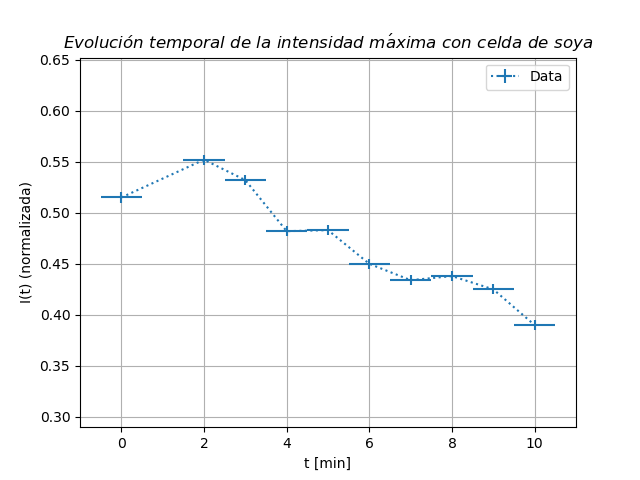

In [14]:
x=dat.tmin
xerrl=dat.dtmin
avl=dat.ma
yerrl=dat.dma
plt.errorbar(x,avl,xerr=xerrl,yerr=yerrl,ls=':',label='Data')
plt.xscale("linear")
plt.yscale("linear")
plt.xlim(x.min()-1,x.max()+1)
plt.ylim(np.array(avl).min()-0.1,np.array(avl).max()+0.1)
plt.locator_params(numticks=10)
plt.xlabel("t [min]")
plt.ylabel("I(t) (normalizada)")
plt.grid(True)
plt.legend()
plt.title(r'$Evolución\ temporal\ de\ la\ intensidad\ m\'axima\ con\ celda\ de\ soya$')
plt.show()

<IPython.core.display.Javascript object>


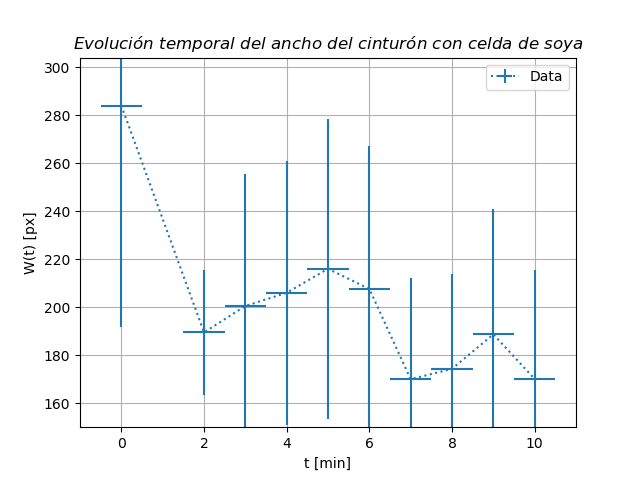

In [15]:
x=dat.tmin
xerrl=dat.dtmin
avl=dat.Wpx
yerrl=dat.dWpx
plt.errorbar(x,avl,xerr=xerrl,yerr=yerrl,ls=':',label='Data')
plt.xscale("linear")
plt.yscale("linear")
plt.xlim(x.min()-1,x.max()+1)
plt.ylim(np.array(avl).min()-20,np.array(avl).max()+20)
plt.locator_params(numticks=10)
plt.xlabel("t [min]")
plt.ylabel("W(t) [px]")
plt.grid(True)
plt.legend()
plt.title(r'$Evolución\ temporal\ del\ ancho\ del\ cinturón\ con\ celda\ de\ soya$')
plt.show()

In [6]:
dat

,tmin,dtmin,ma,dma,Wpx,dWpx
0,0,0.5,0.515,0.005,284.1,92.3
1,2,0.5,0.552,0.005,189.6,26.1
2,3,0.5,0.532,0.005,200.6,55.1
3,4,0.5,0.482,0.005,206.1,55.0
4,5,0.5,0.483,0.005,216.1,62.5
5,6,0.5,0.450,0.005,207.7,59.4
6,7,0.5,0.434,0.005,170.1,42.3
7,8,0.5,0.438,0.005,174.4,39.6
8,9,0.5,0.425,0.005,188.8,52.2
9,10,0.5,0.390,0.005,170.2,45.4
